<a href="https://colab.research.google.com/github/SajalSinha/Corona_tweet_sentimental_Analysis/blob/main/Coronavirus_Tweet_Sentiment_Analysis_Capstone_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

#Downloading libraries

In [183]:
#for data manipulation
import pandas as pd
import numpy as np
import re
import string

#for preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#for ML
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [184]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [185]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [186]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [187]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Getting Data

In [188]:
# from google.colab import drive
# drive.mount('/content/drive')

In [189]:
df = pd.read_csv("https://raw.githubusercontent.com/SajalSinha/Corona_tweet_sentimental_Analysis/main/Coronavirus%20Tweets.csv",encoding='latin-1')

In [190]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [191]:
pd.DataFrame(df.isnull().mean()*100,columns=['Null Percentage'])

,Null Percentage
UserName,0.000000
ScreenName,0.000000
Location,20.871298
TweetAt,0.000000
OriginalTweet,0.000000
Sentiment,0.000000


In [192]:
df['Location'] = df['Location'].fillna(df['Location'].mode())

In [193]:
df['Location'].isnull().sum()

8590

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


#EDA

In [195]:
count = df.isnull().sum().sort_values(ascending = False)

In [196]:
percentage = ((df.isnull().sum())/len(df)*100).sort_values(ascending=False)

In [197]:
missing_data = pd.concat([count,percentage],axis=1,keys=['Count','Percentage'])

In [198]:
missing_data

,Count,Percentage
Location,8590,20.871298
Sentiment,0,0.000000
OriginalTweet,0,0.000000
TweetAt,0,0.000000
ScreenName,0,0.000000
UserName,0,0.000000


In [199]:
df["Location"].fillna(df['Location'].mode().iloc[0],inplace=True)

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Sentiment distributions')

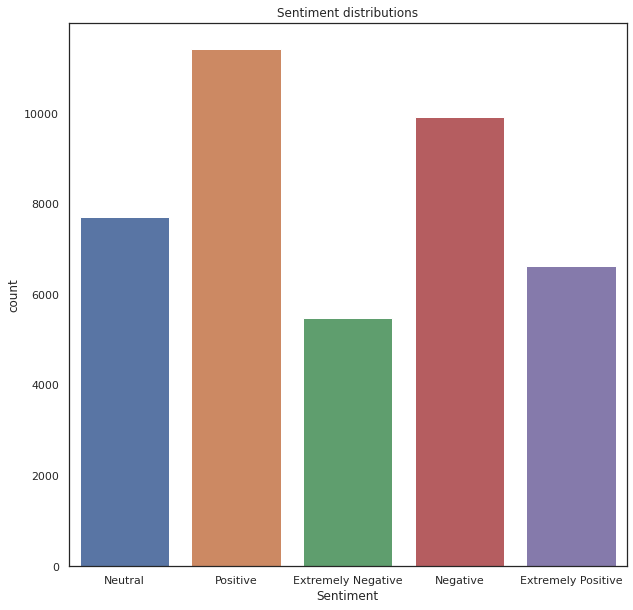

In [201]:
plt.figure(figsize=(10,10))
sns.countplot(x=df['Sentiment'])
plt.title('Sentiment distributions')

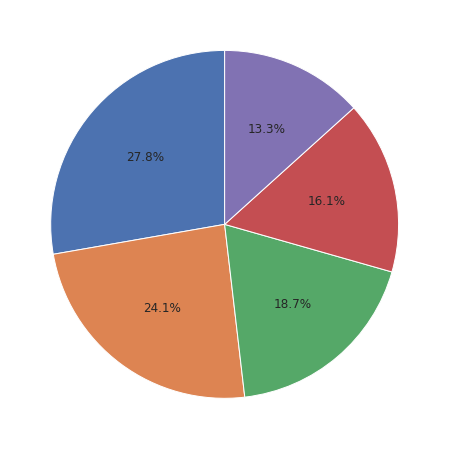

In [202]:
fig1, ax1 = plt.subplots()
ax1.pie(df['Sentiment'].value_counts(), autopct='%1.1f%%',shadow=False,startangle=90)
plt.show()

In [203]:
list(df.loc[df["Sentiment"]=='Negative','OriginalTweet'])[0]

"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona"

In [204]:
list(df.loc[df["Sentiment"]=='Positive','OriginalTweet'])[0]

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [205]:
list(df.loc[df["Sentiment"]=='Neutral','OriginalTweet'])[0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [206]:
Top_Location_Of_tweet= df['Location'].value_counts().head(10)

In [207]:
Top_Location_Of_tweet_df=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet_df.reset_index(inplace=True)
Top_Location_Of_tweet_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
Top_Location_Of_tweet_df

,Location,Location_Count
0,London,9130
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


In [208]:
count_of_tweets = list(df['TweetAt'].value_counts())
date_of_tweets = list(df['TweetAt'].unique())
date_df = pd.DataFrame(list(zip(date_of_tweets,count_of_tweets)),columns=['Date','Count of Tweets'])
date_df.sort_values(by=['Count of Tweets'],ascending=False).head(10)

,Date,Count of Tweets
0,16-03-2020,3448
1,17-03-2020,3215
2,18-03-2020,2979
3,19-03-2020,2742
4,20-03-2020,2653
5,21-03-2020,2114
6,22-03-2020,2062
7,23-03-2020,1977
8,24-03-2020,1881
9,25-03-2020,1843


In [209]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,London,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,London,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [210]:
neg_phrases = df[df.Sentiment == 'Negative']
neg_words = []
for t in neg_phrases.OriginalTweet:
    neg_words.append(t)
neg_words[:4]

["For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona",
 '@10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checkout staff to police the actions of the selfish and profiteer',
 'In preparation for higher demand and a potential food shortage, The Hunger Coalition purchased 10 percent more food and implemented new protocols due to the COVID-19 coronavirus. https://t.co/5CecYtLnYn',
 'Do you see malicious price increases in NYC? The NYC Department of Consumer and Worker Protection (DCWP) has set up a page to digitally file a complaint. Click here: https://t.co/oEx6Y8mm2K\r\r\n\r\r\nTo file a complaint (use the word"Overcharge") https://t.c

In [211]:
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:100]

'For corona prevention,we should stop to buy things with the cash and should use online payment metho'

In [212]:
for t in neg_phrases.OriginalTweet[:300]:
    if 'good' in t:
        print(t)




#Covid_19 https://t.co/pzirO10avf
People seen stocking up on goods into trolleys after the panic buying rumours spread today at hypermarket in Kajang March 16 2020 Picture by Shafwan Zaidon



yet, Korea's supermarket never out of stock while Malaysia.....empty shelf here and there. The government should totally consider on limiting some necessity goods to every consumer in the market.
@nytopinion @McDonalds @SUBWAY @ChickfilA @CrackerBarrel @Outback @Cheesecake You asked the workers, we asked the restaurants! HereÂs what the top 20 are offering during the outbreak (hint: itÂs not good): https://t.co/e2ZNXajPre

#CoronavirusOutbreak #coronavirus #CoronaVirusUpdates #panicbuying #COVID2019 #COVID19 #COVID?19 #Repost #QuarantineLife #QuarantineAndChill #SocialDistance #StayTheFHome #Corona #wtf https://t.co/yQrUtMwgw9








Thread ?
Seattle to provide $800 in supermarket vouchers to thousands of families during coronavirus crisis, mayor says https://t.co/jupy1W34KK to more than 6,

In [213]:
pos_phrases = df[df.Sentiment == "Positive"] ## 4 is positive sentiment
pos_string = []
for t in pos_phrases.OriginalTweet:
    pos_string.append(t)
pos_text = pd.Series(pos_string).str.cat(sep=' ')
pos_text[:100]

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbe'

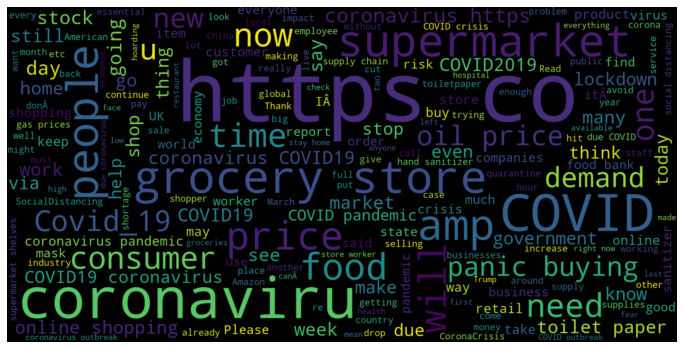

In [214]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

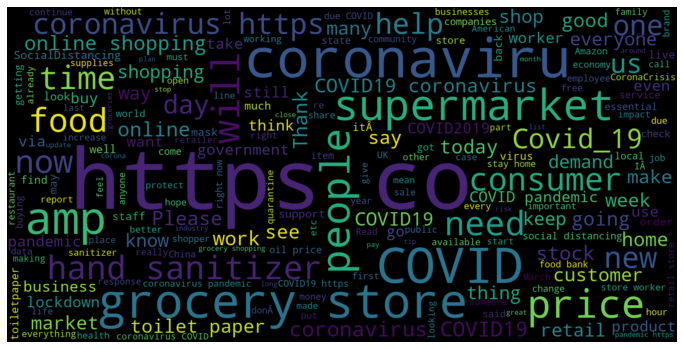

In [215]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Preprocessing data

In [216]:
df.drop(['UserName','ScreenName','Location','TweetAt'],axis=1,inplace=True)

In [217]:
def preprocessing_text(data):
  data =data.lower()
  data = re.sub(r'http\S+|www\S+|https\S',' ',data,flags=re.MULTILINE)
  data = data.translate(str.maketrans('','',string.punctuation))
  data = re.sub(r'\@\w+|\#'," ", data)
  data_token = word_tokenize(data)
  filtered_words = [word for word in data_token if word not in stop_words]
  ps = PorterStemmer()
  stemmed_words = [ps.stem(w) for w in filtered_words]
  lemmatizer = WordNetLemmatizer()
  lemma_words = [lemmatizer.lemmatize(w,pos='a') for w in stemmed_words]
  return ' '.join(lemma_words)

In [218]:
df['Processed_text'] = df['OriginalTweet'].apply(preprocessing_text)

In [219]:
df.head()

,OriginalTweet,Sentiment,Processed_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbi philgahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,My food stock is not the only one which is emp...,Positive,food stock one empti pleas dont panic enough f...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,readi go supermarket covid19 outbreak im paran...


In [220]:
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [221]:
encoders_nums = {"Sentiment":{"Neutral": 'Neutral' ,"Positive": 'Positive','Extremely Negative':'Negative','Extremely Positive':'Positive','Negative':'Negative'}}
df = df.replace(encoders_nums)

In [222]:
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

#Model Training

In [223]:
x = df.Processed_text
y = df.Sentiment
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.1,random_state = 225)
print('x_train: ',len(x_train))
print('x_test: ',len(x_test))
print('y_train: ',len(y_train))
print('y_test: ',len(y_test))

x_train:  37041
x_test:  4116
y_train:  37041
y_test:  4116


In [224]:
tvec = TfidfVectorizer()
clf2 = LogisticRegression(solver = 'lbfgs')

In [225]:
from sklearn.pipeline import Pipeline

In [226]:
model = Pipeline([('vectorizer',tvec),('classifier',clf2)])
model.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, inter

In [227]:
from sklearn.metrics import confusion_matrix

In [228]:
predictions = model.predict(x_test)
prediction_train = model.predict(x_train)

[Text(0, 0.5, 'neutral'), Text(0, 1.5, 'positive'), Text(0, 2.5, 'negative')]

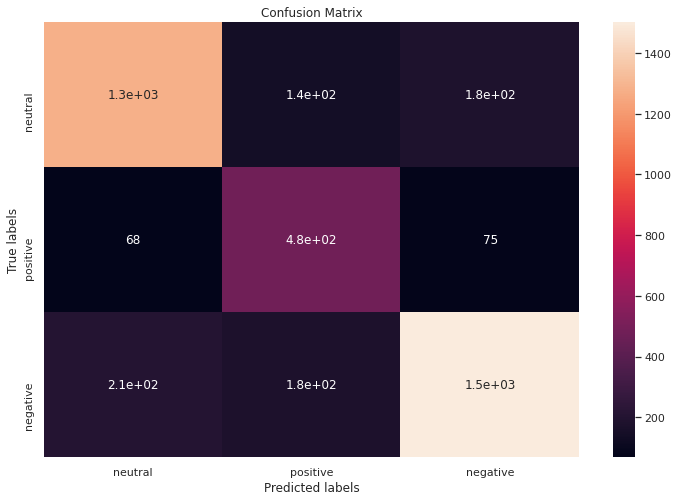

In [230]:
cm_test = confusion_matrix(predictions,y_test)
ax= plt.subplot()
sns.heatmap(cm_test, annot=True, ax = ax) #annot=True to annotate cells
labels = ['neutral', 'positive','negative']
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

[Text(0, 0.5, 'neutral'), Text(0, 1.5, 'positive'), Text(0, 2.5, 'negative')]

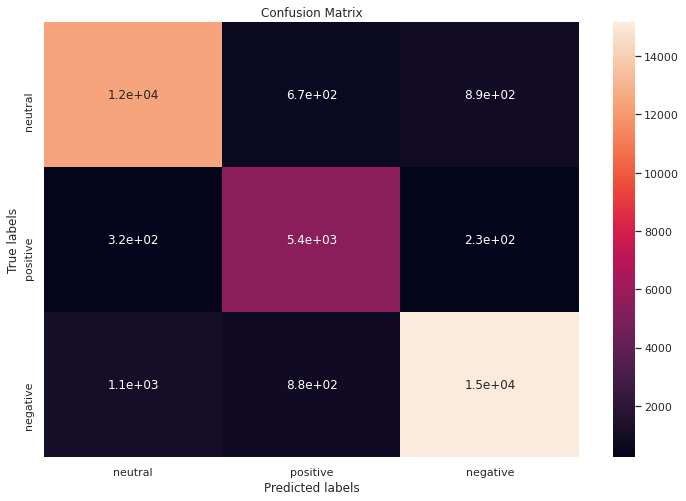

In [232]:
cm_train = confusion_matrix(prediction_train,y_train)
ax= plt.subplot()
sns.heatmap(cm_train, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
print('Accuracy score of train set: ',accuracy_score(prediction_train,y_train))
print('Precission of train set: ',precision_score(prediction_train,y_train, average = 'weighted'))
print('Recall of train set: ',recall_score(prediction_train,y_train, average = 'weighted'))

Accuracy score of train set:  0.8908776760886585
Precission of train set:  0.8948535506549515
Recall of train set:  0.8908776760886585


In [ ]:
print('Accuracy score of test set: ',accuracy_score(predictions,y_test))
print('Precission of test set: ',precision_score(predictions,y_test, average = 'weighted'))
print('Recall of test set: ',recall_score(predictions,y_test, average = 'weighted'))

Accuracy score of test set:  0.7920310981535471
Precission of test set:  0.802662900884536
Recall of test set:  0.7920310981535471


In [ ]:
print(classification_report(y_test,predictions))
print("\n")
print(classification_report(y_train,prediction_train))

              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81      1552
     Neutral       0.77      0.60      0.67       803
    Positive       0.80      0.85      0.82      1761

    accuracy                           0.79      4116
   macro avg       0.79      0.76      0.77      4116
weighted avg       0.79      0.79      0.79      4116



              precision    recall  f1-score   support

    Negative       0.89      0.90      0.89     13846
     Neutral       0.91      0.78      0.84      6910
    Positive       0.89      0.93      0.91     16285

    accuracy                           0.89     37041
   macro avg       0.89      0.87      0.88     37041
weighted avg       0.89      0.89      0.89     37041



#Try Example

In [ ]:
example = ['Today is a good day']
result = model.predict(example)
print(result)

['Positive']
